In [6]:
from python.AReS import Simulator, Model, SimulatorMode, Interaction, DoHMeasure, TciMode

import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_trend(results, input, input_range, variables_to_plot, scenario_indexes, cmap_name="tab10", figsize=(6, 4), y_label="Trend"):
    """
    Generate a plot with a shaded area spanning between the min and max scenario values,
    and a single line for the middle scenario.

    :param results: Dictionary containing simulation results for each scenario.
    :param variables: Dictionary of variable names and their corresponding labels for plotting.
    :param scenario_indexes: List of scenario indexes to include in the plot.
    :param input_range: Input range values over which trends are to be plotted.
    :param output_path: Path to save the trend plot.
    :param cmap_name: Name of the colormap for line colors.
    :param figsize: Size of the figure.
    """

    colormap = plt.colormaps[cmap_name]
    print(f'-------------Analyzing trends for {input}-------------')

    # Markers for the middle scenario
    markers = ['o', 's', '^', 'D', 'x', 'p', '*', 'h']

    plt.figure(figsize=figsize)

    for j, (variable, label) in enumerate(variables_to_plot.items()):
        all_last_values = []

        for scenario, values in results.items():
            if variable in values:
                last_values = [arr[-1] for arr in values[variable] if len(arr) > 0]
                all_last_values.append(last_values)

        if not all_last_values:
            print(f"No data for variable '{variable}'. Skipping.")
            continue

        # Convert to numpy array for the computation of min, max, and median
        all_last_values = np.array(all_last_values)

        # Calculate min, max, and median
        min_values = np.min(all_last_values, axis=0)
        max_values = np.max(all_last_values, axis=0)
        median_values = np.median(all_last_values, axis=0)

        # Calculate step differences
        step_differences = {}
        for i in range(len(all_last_values)): # this is the number of scenarios
            print(f"Scenario {scenario_indexes[i]} for {variable}: {all_last_values[i]}")
            # i interate on the scenarios and j iterate on the simulations with different input values
            # step_differences[i] contains the differences between the steady state value using the jth input and the jth-1 input for scenario i
            step_differences[i] = [abs(all_last_values[i][j] - all_last_values[i][j-1]) for j in range(1, len(all_last_values[i]))]
            
        for step in step_differences.values():
            print(f"Step differences for {variable}: {step}")

        # Plot shaded area between min and max
        color = colormap(j / len(variables))

        differences = abs(max_values - min_values) # calculate the differences between the min and max values for each scenario

        # Plot the middle (median) line
        marker = markers[j % len(markers)]  # Cycle through markers
        plt.plot(input_range, median_values,
                 label=f"{label}", color=color, alpha=0.8,
                 marker=marker, linestyle='-', linewidth=1.2, markersize=2.5)
        plt.xticks(input_range, input_range)

        if any(differences > 0.5): # if the differences between the scenarios are greater than 0.5, fill the area between the min and max values for clarity
            plt.fill_between(input_range, min_values, max_values,
                                 color=color, alpha=0.3, label=f"{label} across scenarios")
            plt.plot(input_range, min_values, color=color, alpha=0.5, linestyle='--',marker=marker, linewidth = 1.0, markersize=1.5)
            plt.plot(input_range, max_values, color=color, alpha=0.5, linestyle='--',marker=marker, linewidth = 1.0, markersize=1.5)

    plt.xlabel(f"{input} Range")
    plt.ylabel(y_label)
    plt.grid(axis='y', color='gray', alpha=0.3)

    plt.legend(
        fontsize='x-small',  # Smaller font size
        labelspacing=0.2,  # Reduced spacing between labels
        markerscale=0.8,  # Smaller marker size
        handlelength=1.0,  # Shorter lines in the legend
        borderpad=0.3,  # Compact padding around the legend
        handletextpad=0.4  # Reduced padding between markers and text
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    plt.close()


In [8]:
def plot_trace(ax, x, y_data, ylabel, id_ref, label_prefix=None, color=None, add_legend=False):
    """
    Plot a trace with shaded min/max variability on a given axis.
    """
    y_data = np.array(y_data)
    y_ref = y_data[id_ref] # Plot the reference trace
    y_min = np.min(y_data, axis=0) # Min trace
    y_max = np.max(y_data, axis=0) # Max trace

    if color is None:
        colormap = plt.colormaps['tab10']
        color = colormap(len(ax.lines) % 10)  # tab10 has 10 distinct colors, avoid going over

    label_prefix = '' if label_prefix is None else label_prefix
    ax.plot(x, y_ref, color=color, label=f'{label_prefix} Mean Trace')  # Main trace (mean)
    ax.fill_between(x, y_min, y_max, color=color, alpha=0.2, label=f'{label_prefix} Min/Max Range')  # Shaded area (min/max)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(ylabel)
    ax.grid(True)
    if add_legend:
        ax.legend(loc="upper right")


def plot_data(data, id_ref, field=None, labels=None):
    """
    Plot a single scenario's patient response with variability for multiple data fields.
    """
    if field is None:
        fields = [
            '_u_prop_all', '_u_remi_all', '_cp_prop_all', '_cp_remi_all', '_ce_prop_all', '_ce_remi_all', '_u_nore_all', '_c_nore_all',
            '_WAV_all', '_BIS_all', '_MAP_all', '_CO_all', '_HR_all', '_SV_all'
        ]

        labels = [
            '$u_{Prop} [mg/s]$', '$u_{Remi} [μg/s]$', '$C_{p,prop} [μg/ml]$', '$C_{p,remi} [ng/ml]$',
            '$C_{e,prop} [μg/ml]$', '$C_{e,remi} [ng/ml]$',
            '$u_{Nore} [μg/s]$', '$C_{nore} [ng/ml]$',
            'WAV$_{cns}$', 'BIS', 'MAP [mmHg]',
            'CO [L/min]', 'HR [beats/min]', 'SV [ml]'
        ]
    else:
        fields = field
        labels = labels

    data_values = [data[field] for field in fields]
    t_sim = np.arange(0, len(data['_u_prop_all'][0]))/60  # Time vector

    cols = 2
    rows = len(data_values) // cols
    subplot_width = 7
    subplot_height = 3
    fig_width = subplot_width * cols
    fig_height = subplot_height * rows
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height)) 

    for i, (values, label) in enumerate(zip(data_values, labels)):
        plot_trace(axs[i // 2, i % 2], t_sim, values, label, id_ref)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
def run_simulations(variable_input, range_values, scenario_indexes):
    simulation_params = [
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.ELEVELD, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.MINTO}},
        {'pk_models': {'prop': Model.SCHNIDER, 'remi': Model.ELEVELD},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}},
        {'pk_models': {'prop': Model.SCHNIDER, 'remi': Model.MINTO},
         'pd_models': {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.MINTO}}
    ]

    interaction = Interaction.SURFACE
    doh_measure = DoHMeasure.BOTH

    modes_tci = {'prop': TciMode.EFFECT_SITE, 'remi': TciMode.EFFECT_SITE}
    limits_tci = {'cp_limit_prop': 20, 'cp_limit_remi': 10, 'infusion_limit_prop': 2,
                  'infusion_limit_remi': 0.5}

    t_s = 5
    t_sim = 60 * 30

    u_prop = [2] * t_sim
    u_remi = [3.6] * t_sim
    u_nore = [0] * t_sim
    u_rocu = [0] * t_sim

    patient_id = 29  # patient id 29 is the reference patient because is the most similar to the average patient
    id_ref = 3
    seed = patient_id

    simulator = Simulator.create(SimulatorMode.CONCENTRATION) if not variable_input == 'rocu' else Simulator.create(SimulatorMode.INFUSION)
    results = {}

    simulation_params = [simulation_params[i - 1] for i in scenario_indexes]

    for i, params in enumerate(simulation_params, start=1):
        for input in range_values:

            if variable_input == 'rocu':
                simulator.init_simulation_from_file(
                    id_patient=patient_id, t_sim=t_sim, t_s=t_s,
                    pk_models=params['pk_models'], pd_models=params['pd_models'],
                    interaction=interaction, doh_measure=doh_measure,
                    seed=seed
                )
            else:
                simulator.init_simulation_from_file(
                    id_patient=patient_id, t_sim=t_sim, t_s=t_s,
                    pk_models=params['pk_models'], pd_models=params['pd_models'],
                    pk_models_TCI=params['pk_models'], pd_models_TCI=params['pd_models'],
                    interaction=interaction, doh_measure=doh_measure,
                    stimuli=None, limits_TCI=limits_tci, modes_TCI=modes_tci,
                    volume_status=None, bring_to_maintenance=False,
                    seed = seed
                )

            if variable_input == 'prop':
                u_prop = [input] * t_sim
            elif variable_input == 'remi':
                u_remi = [input] * t_sim
            elif variable_input == 'nore':
                u_nore = [input] * t_sim
            else:
                u_rocu = [input] * t_sim

            simulator.run_complete_simulation(u_prop,u_remi,u_nore,u_rocu)
            simulator.save_simulation()

        data = simulator.get_patient_results()
        pk_models_names = [model.name for model in params['pk_models'].values()]
        pd_models_names = [model.name for model in params['pd_models'].values()]
        simulation_key = f"pk_models: {pk_models_names}, pd_models: {pd_models_names}"
        results[simulation_key] = data
        
        if variable_input == 'rocu':
            fielnames = ['_u_rocu_all', '_cp_rocu_all', '_NMB_m0_all', '_NMB_m1_all', '_NMB_m2_all','_NMB_m3_all']
            labels = ['$u_{Rocu} [mg/s]$', '$C_{p,rocu} [μg/ml]$', 'NMB m0', 'NMB m1', 'NMB m2', 'NMB m3']
        else:
            fielnames = None
            labels = None

        plot_data(data, id_ref, field=fielnames, labels=labels)
        simulator.reset()

    return results

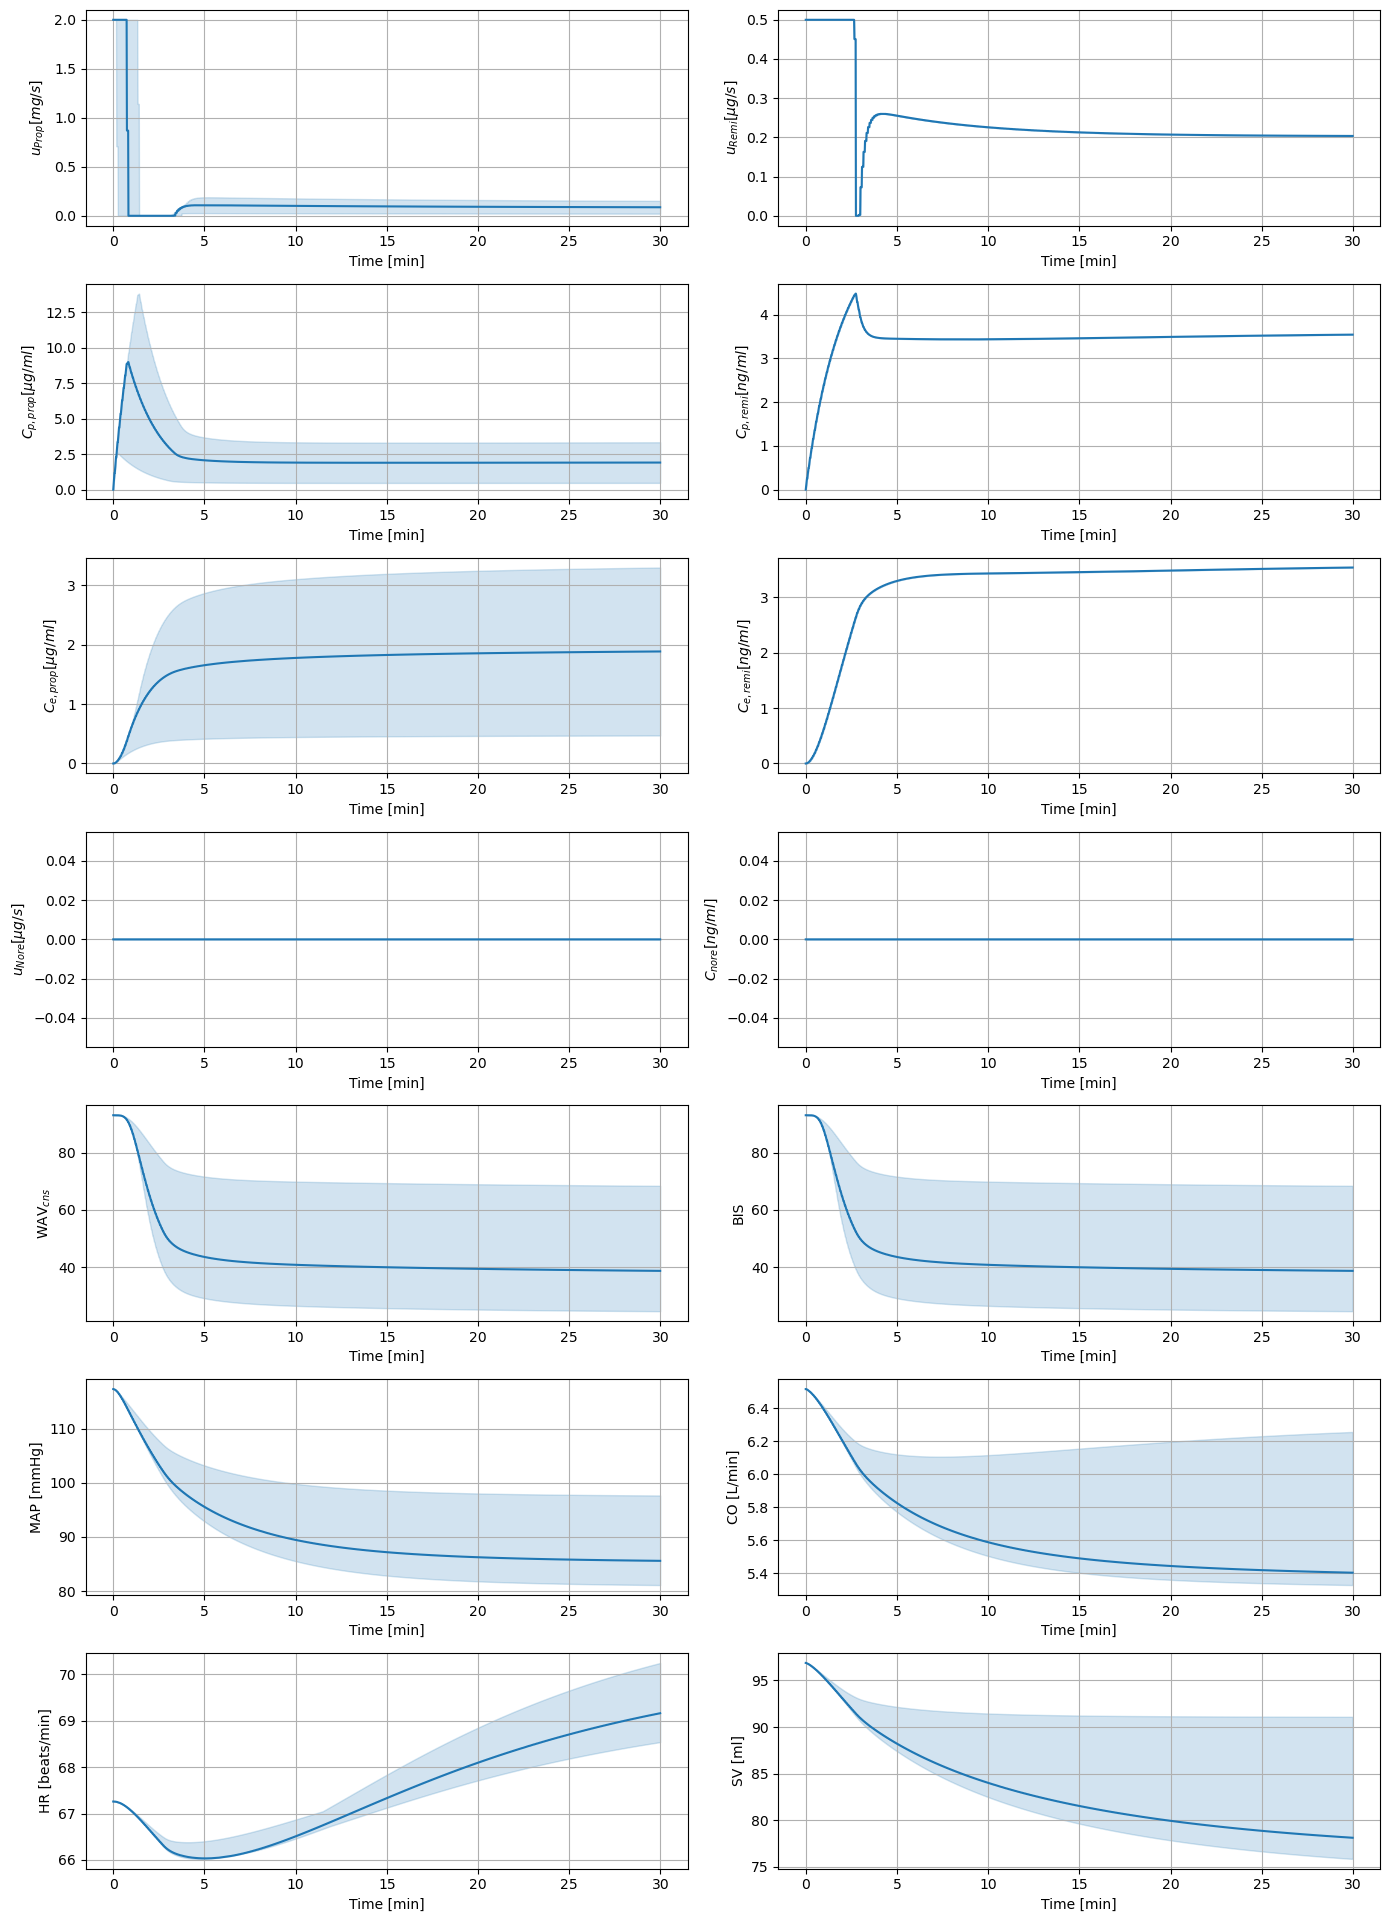

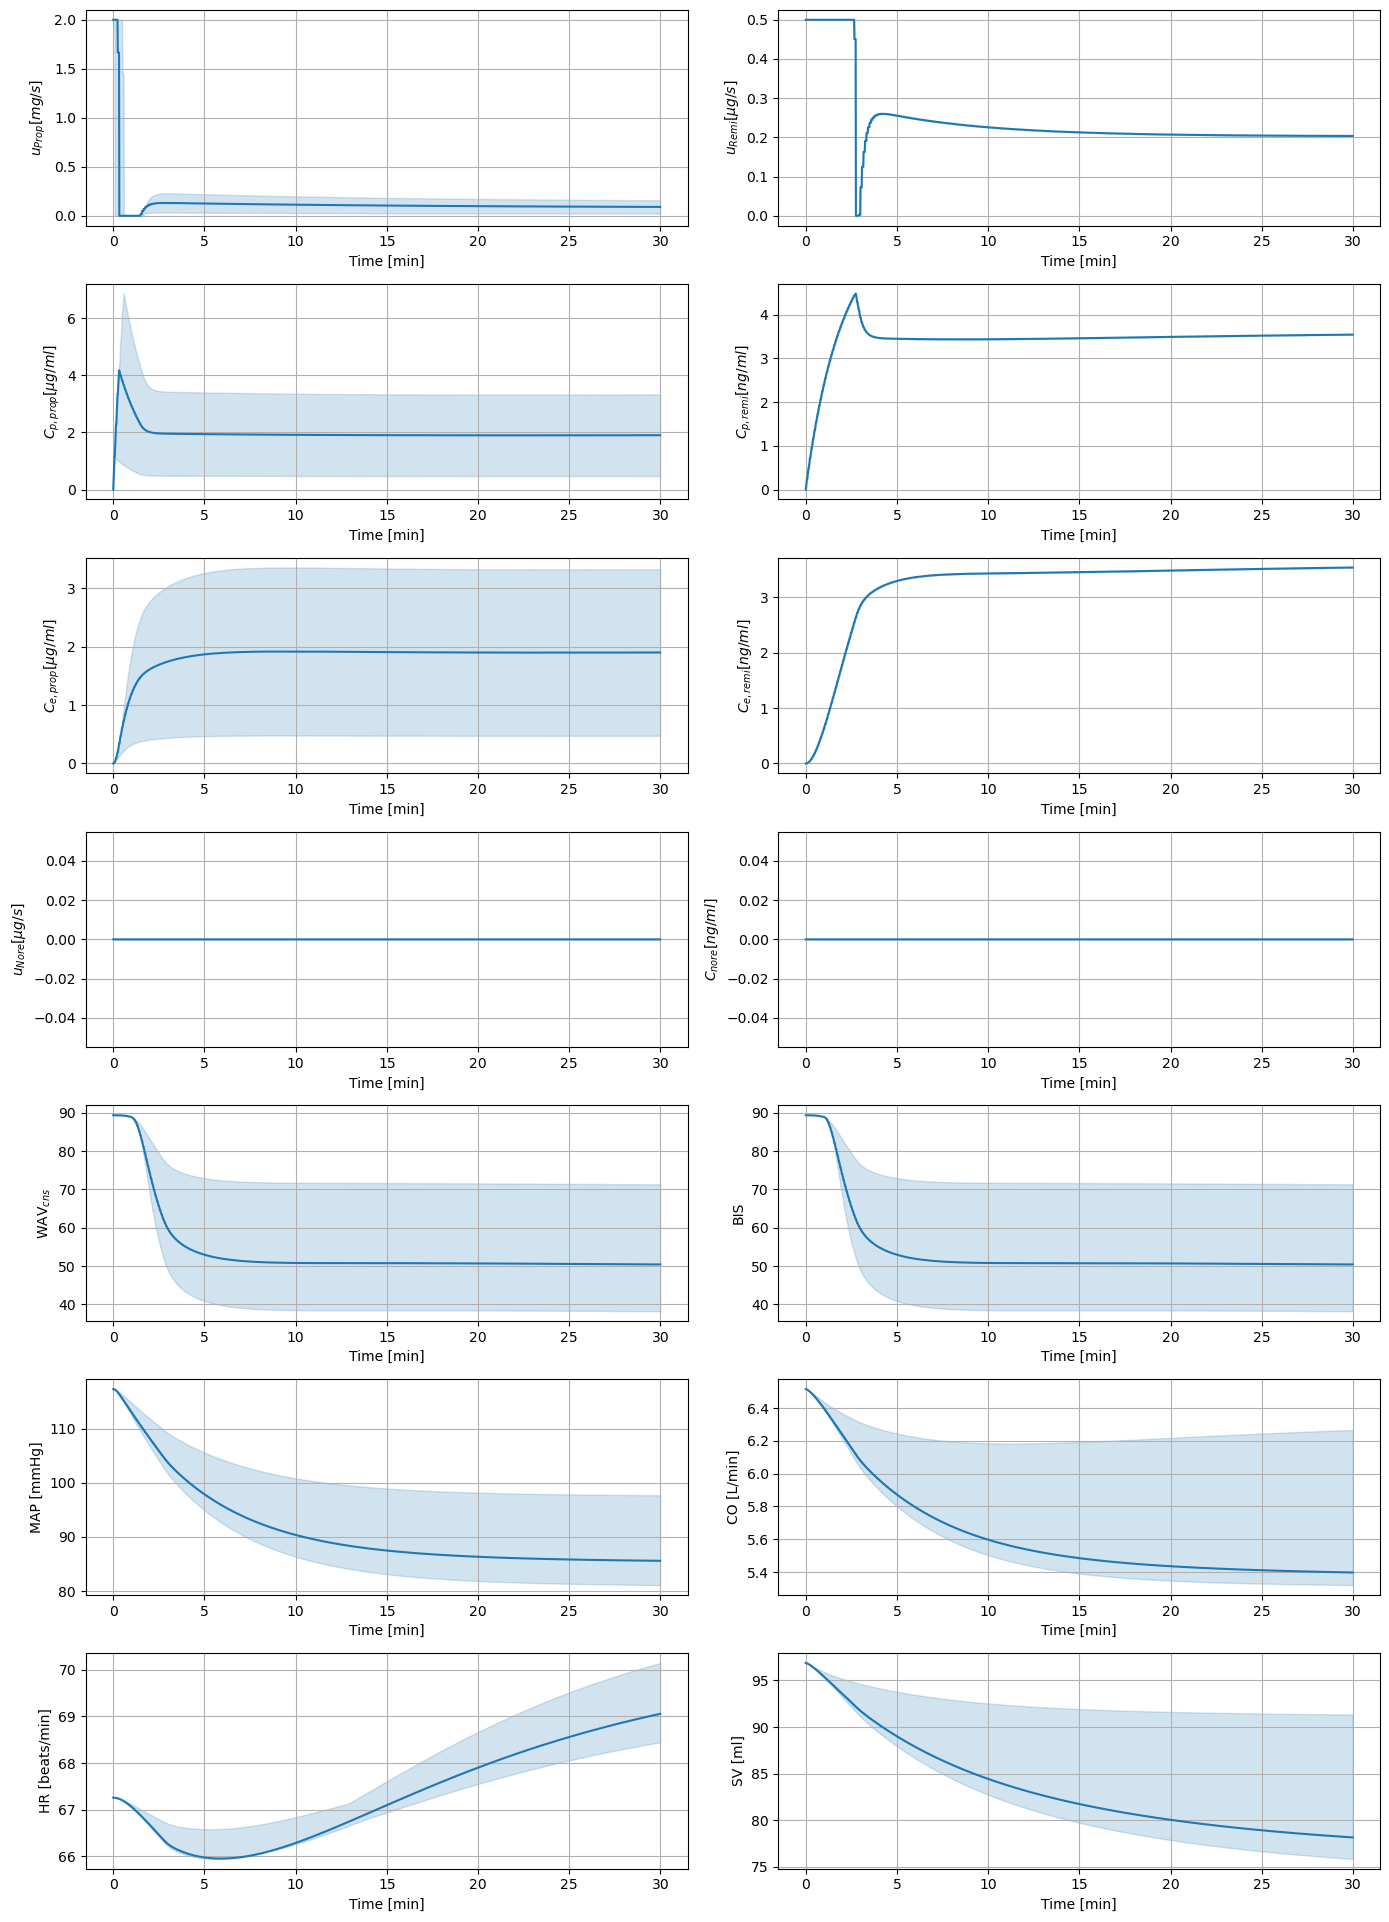

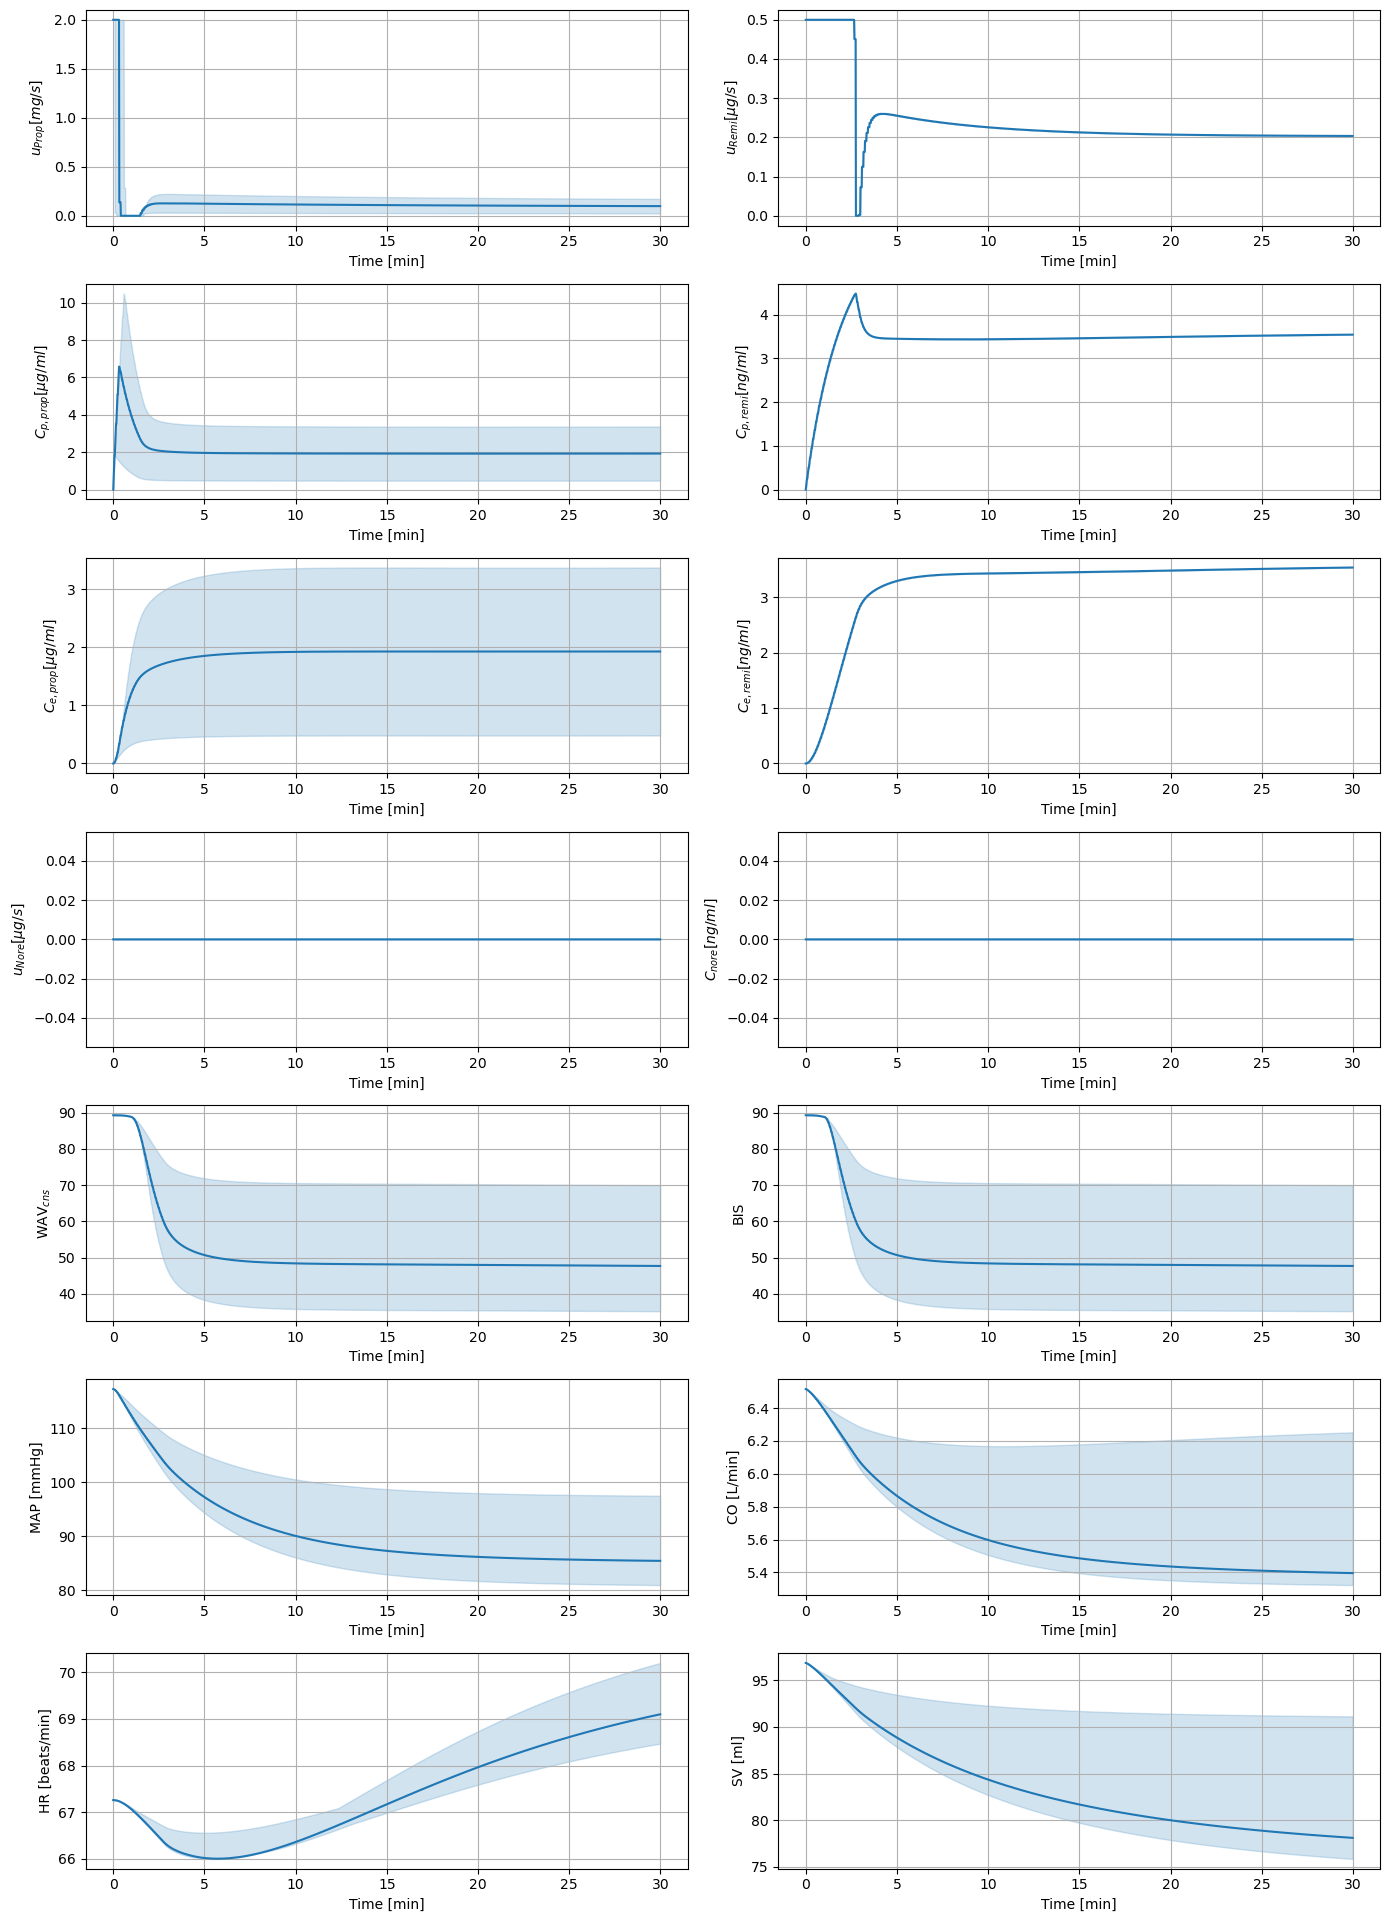

-------------Analyzing trends for prop-------------
Scenario 1 for _WAV_all: [68.38911237 55.37023011 45.94122965 38.71950374 33.00534883 28.40238476
 24.64913012]
Scenario 3 for _WAV_all: [71.31802462 62.85102176 56.01437923 50.43370931 45.75264419 41.73847751
 38.24319323]
Scenario 5 for _WAV_all: [70.02796119 60.76503772 53.51052639 47.68045286 42.83838725 38.72331636
 35.1738642 ]
Step differences for _WAV_all: [13.018882260865958, 9.429000457431535, 7.221725910910138, 5.714154912327764, 4.6029640645850876, 3.753254640581872]
Step differences for _WAV_all: [8.467002862113759, 6.836642530543287, 5.580669921045697, 4.681065117909789, 4.014166681318038, 3.4952842792050376]
Step differences for _WAV_all: [9.262923469409373, 7.254511329695525, 5.830073537403386, 4.842065609275636, 4.115070882702348, 3.549452164152555]
Scenario 1 for _MAP_all: [97.64400828 91.15481165 87.8357049  85.57341814 83.81056599 82.34811787
 81.09953137]
Scenario 3 for _MAP_all: [97.68854983 91.17862406 87.853070

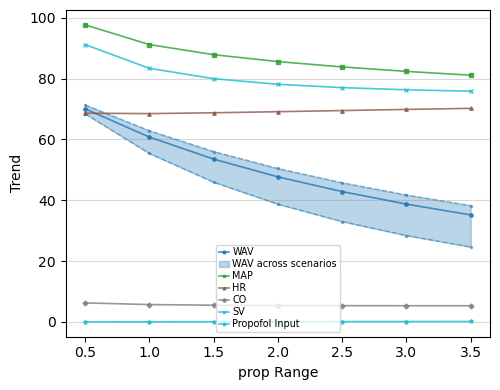

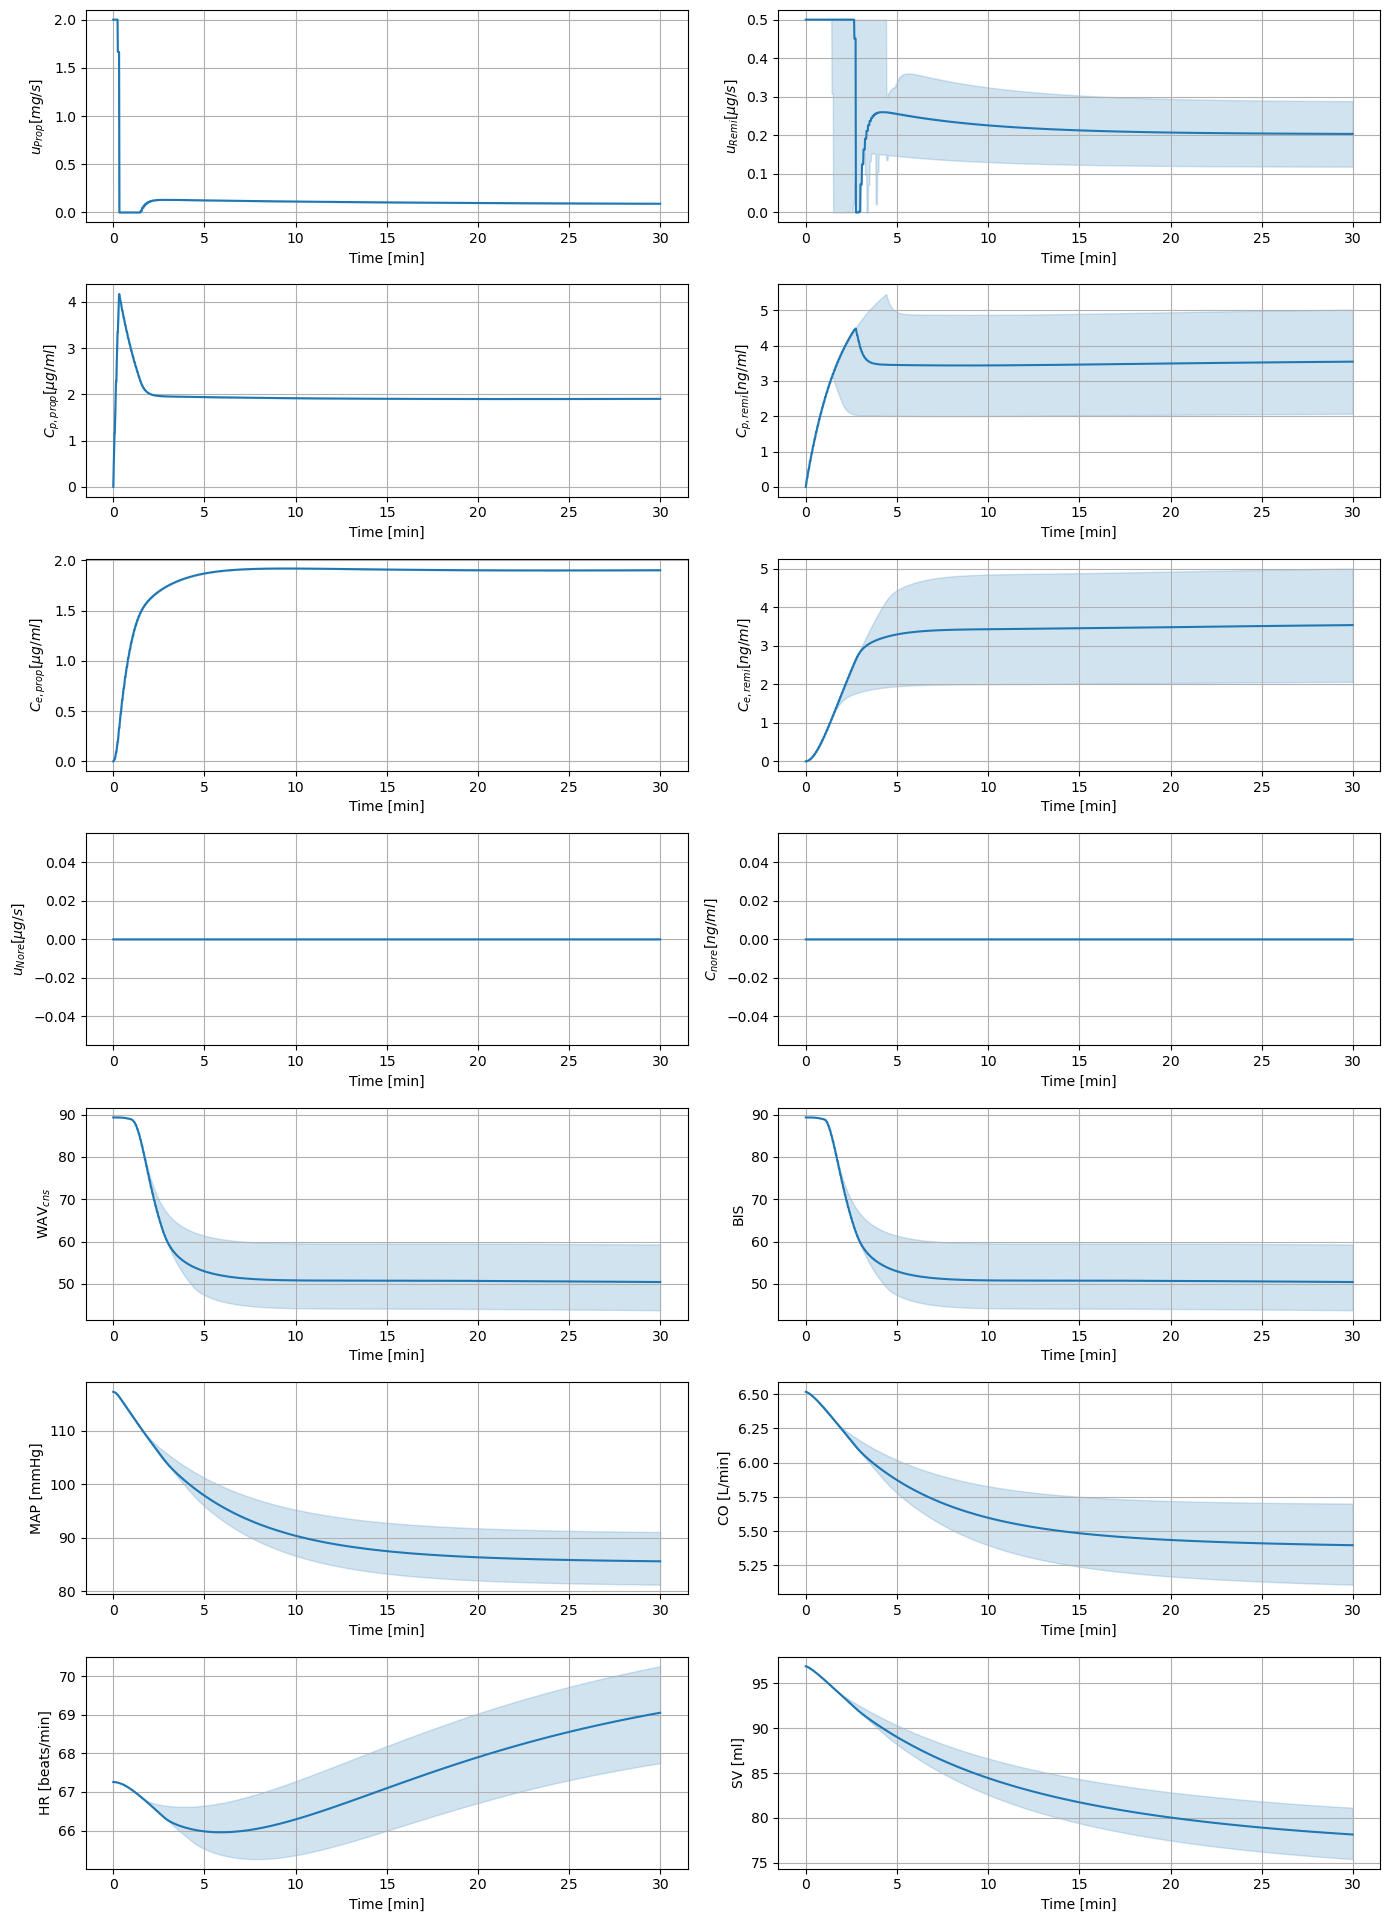

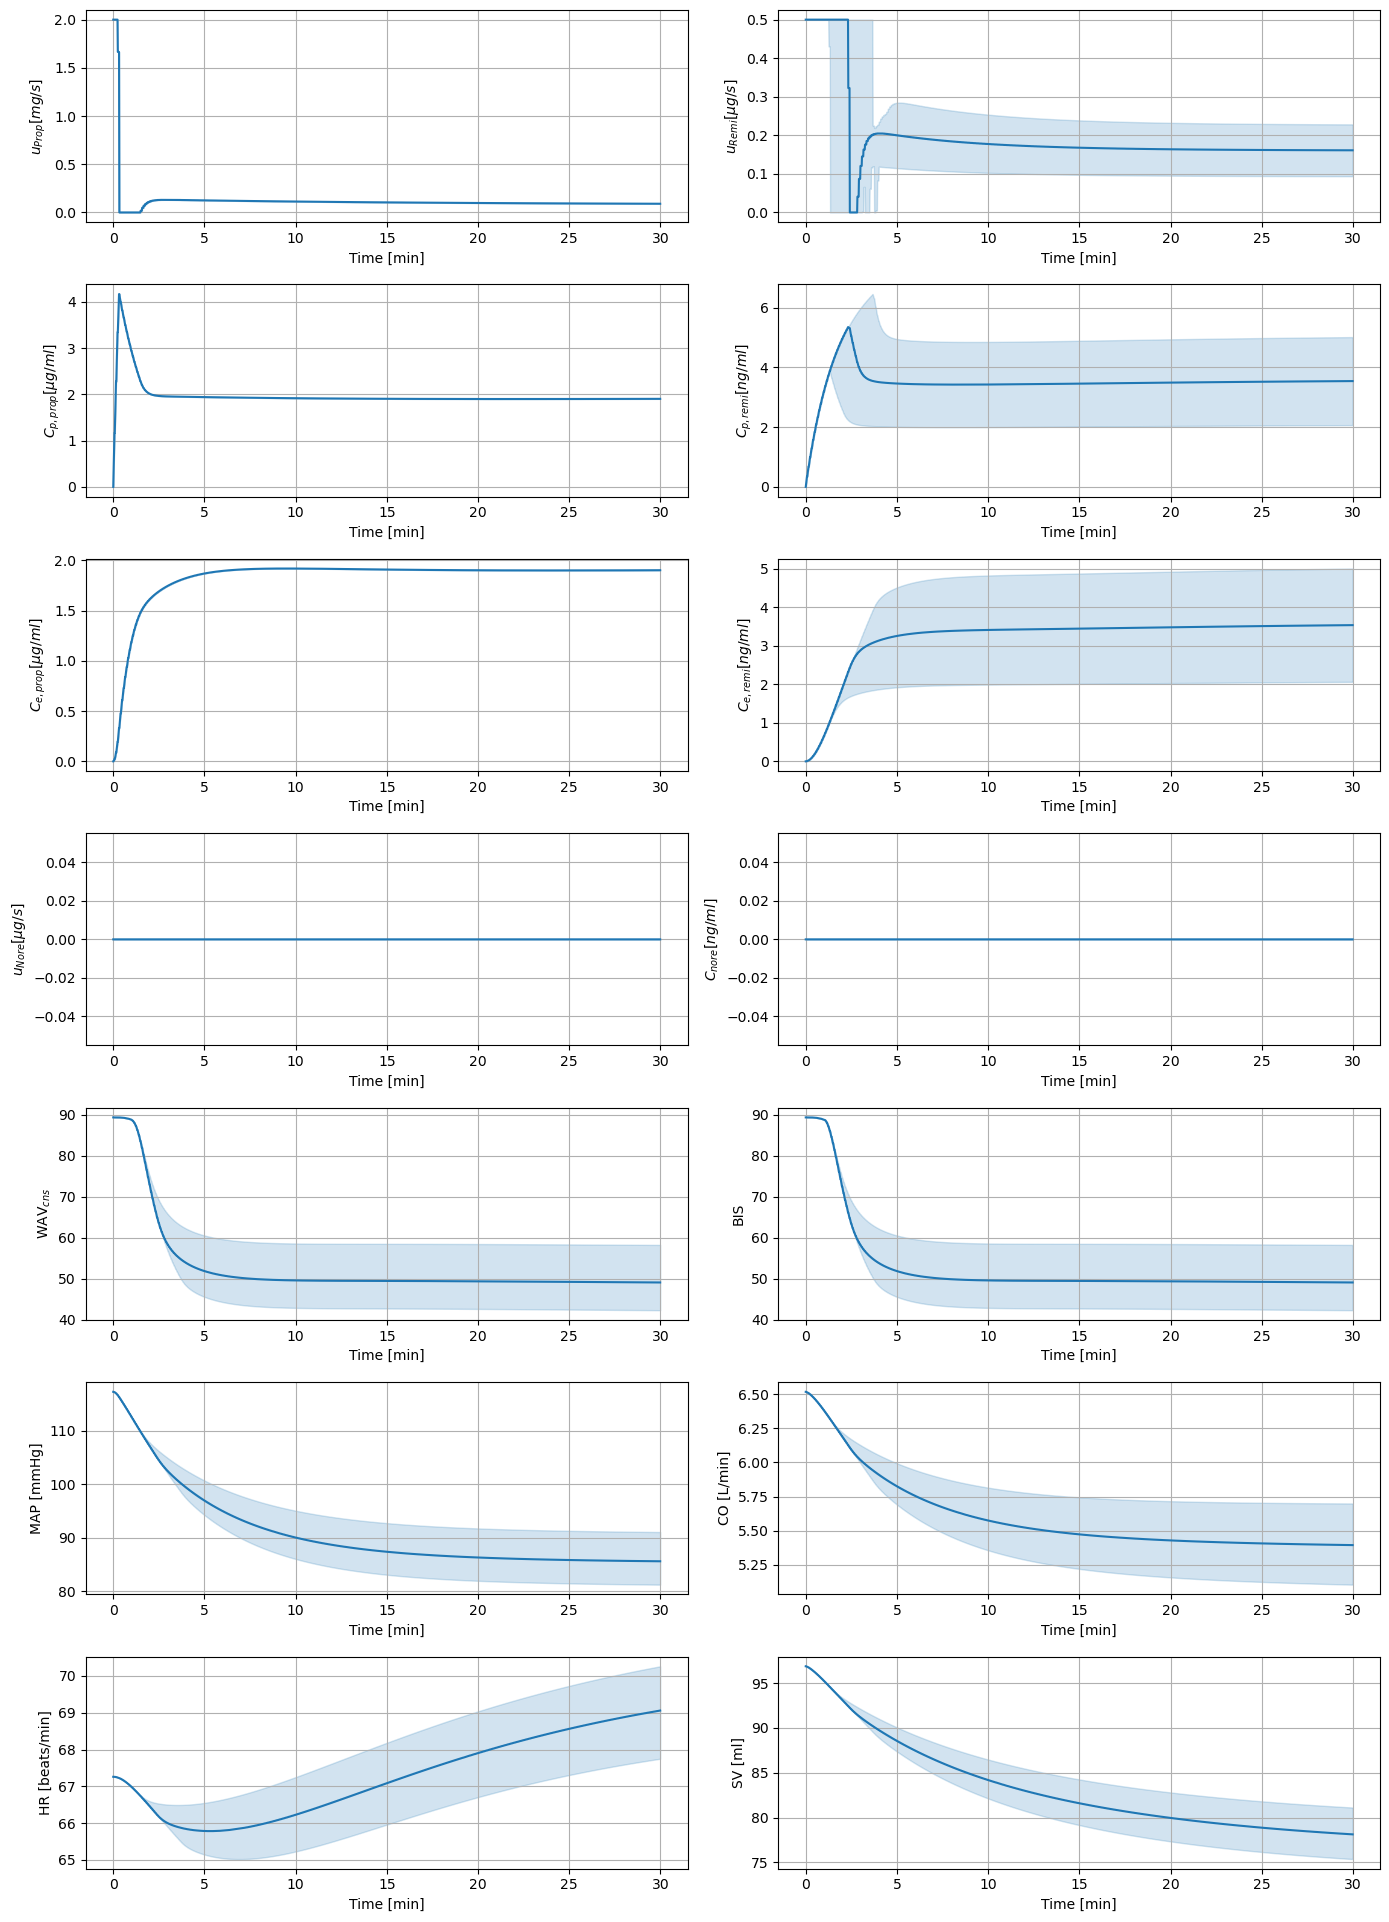

-------------Analyzing trends for remi-------------
Scenario 3 for _WAV_all: [59.30854925 56.05463901 53.10566199 50.43370931 48.00722349 45.79604774
 43.77292056]
Scenario 4 for _WAV_all: [58.20820622 54.82316994 51.77998492 49.04077201 46.56631956 44.32036254
 42.27148481]
Step differences for _WAV_all: [3.2539102382361307, 2.948977025082705, 2.67195268113516, 2.4264858159800937, 2.2111757528075984, 2.023127181419703]
Step differences for _WAV_all: [3.385036276151979, 3.0431850171042214, 2.7392129095422746, 2.4744524518891, 2.2459570231180876, 2.0488777291751177]
Scenario 3 for _MAP_all: [91.06198684 89.07508064 87.2607043  85.58815792 84.03467254 82.58347446
 81.22150649]
Scenario 4 for _MAP_all: [91.05878927 89.07130321 87.25631928 85.58302184 84.02869794 82.57589122
 81.21119591]
Step differences for _MAP_all: [1.9869061992838226, 1.8143763457270694, 1.672546373131624, 1.5534853798788504, 1.45119808432149, 1.3619679729912946]
Step differences for _MAP_all: [1.9874860549757898, 1.8

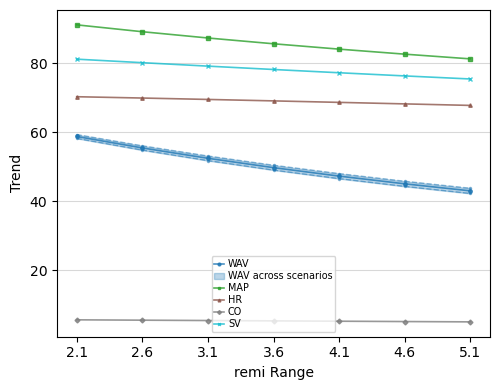

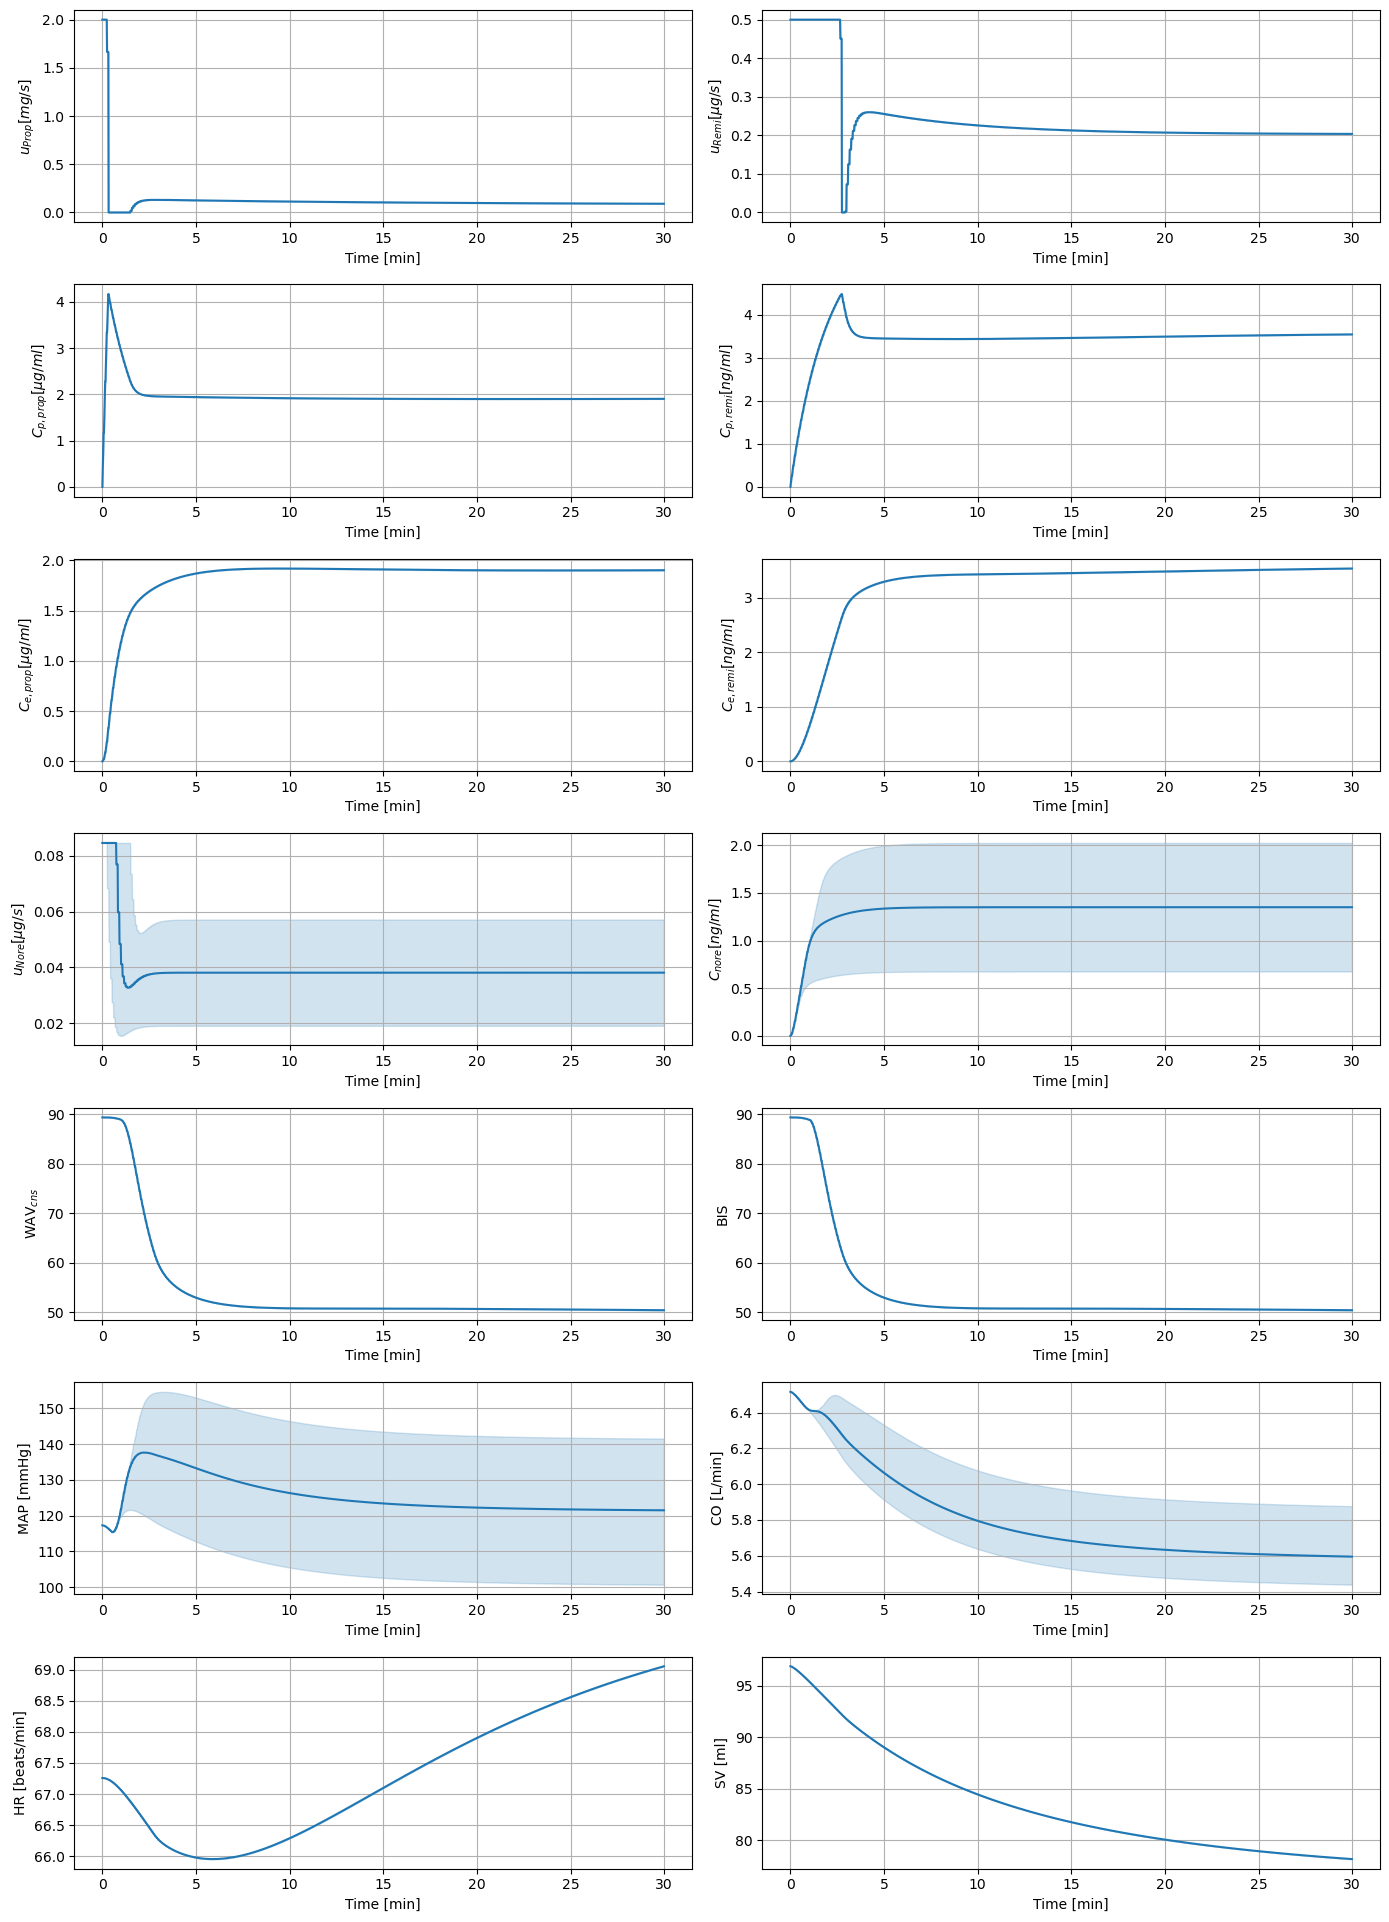

-------------Analyzing trends for nore-------------
Scenario 3 for _MAP_all: [100.72745796 107.55817366 114.53380468 121.48929653 128.33285722
 135.01702172 141.52038906]
Step differences for _MAP_all: [6.830715699882859, 6.97563101482919, 6.95549185209461, 6.843560691993417, 6.684164492666781, 6.5033673481713095]
Scenario 3 for _CO_all: [5.43863515 5.47672668 5.52877417 5.59507521 5.67555174 5.76979308
 5.87709684]
Step differences for _CO_all: [0.038091524136847354, 0.05204749482964033, 0.06630103250183517, 0.08047653357744444, 0.09424134395090267, 0.10730375722451146]


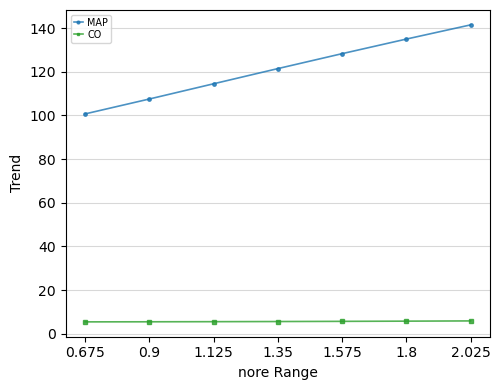

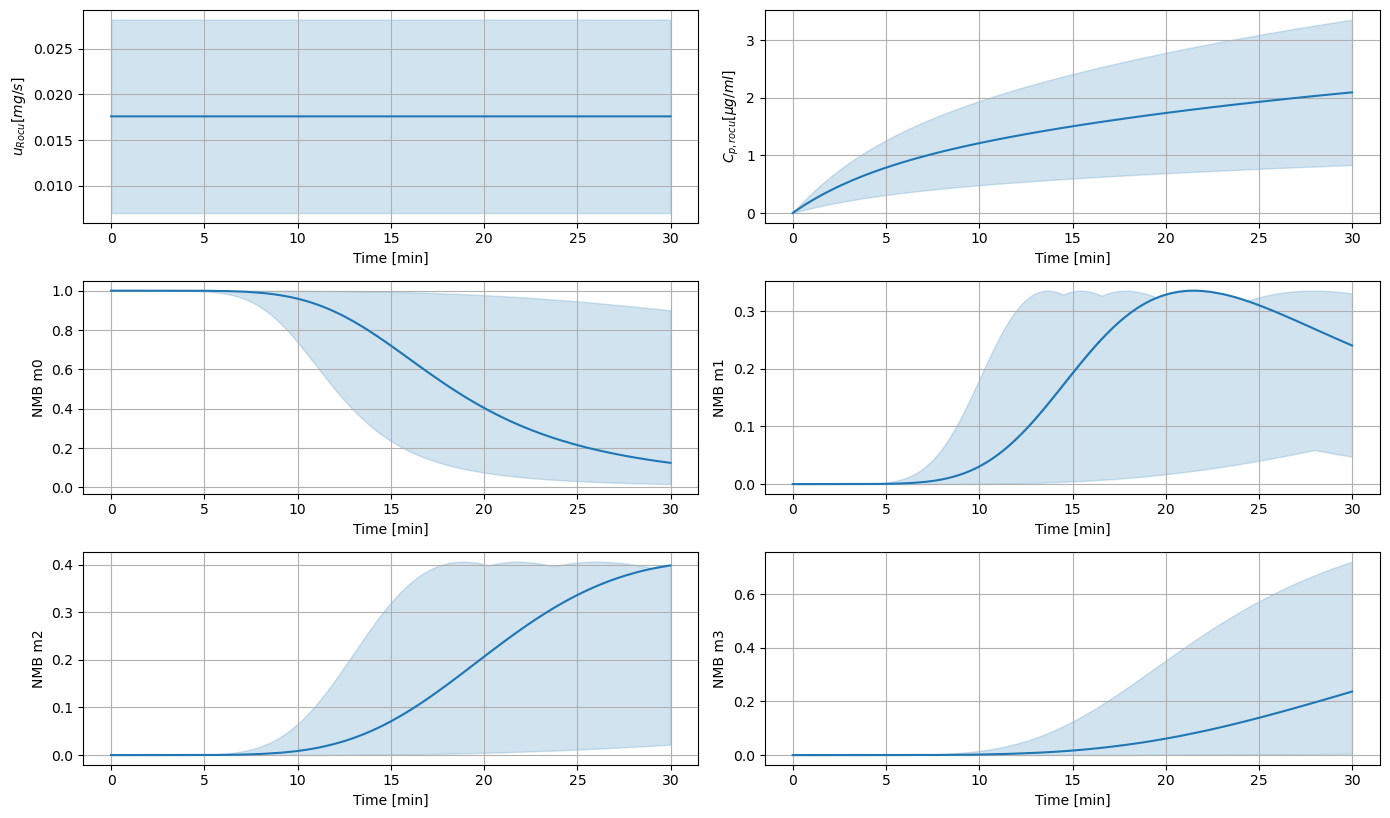

-------------Analyzing trends for rocu-------------
Scenario 3 for _NMB_m0_all: [0.90009179 0.58200208 0.27829274 0.12447656 0.05913993 0.03054543
 0.01675588]
Step differences for _NMB_m0_all: [0.3180897102680301, 0.3037093402762707, 0.15381617966940142, 0.0653366325729805, 0.02859449603438291, 0.01378955561924311]
Scenario 3 for _NMB_m1_all: [0.07315393 0.26698707 0.33062164 0.2402269  0.14328757 0.08231792
 0.04762384]
Step differences for _NMB_m1_all: [0.19383314559500353, 0.06363456936545847, 0.09039474511833151, 0.09693932343570055, 0.06096965678919786, 0.034694080752809]
Scenario 3 for _NMB_m2_all: [0.02187277 0.12024675 0.28826005 0.39816269 0.38474146 0.3033455
 0.21391303]
Step differences for _NMB_m2_all: [0.09837398308205075, 0.16801329781039187, 0.10990263790750149, 0.013421232678675232, 0.08139595228571683, 0.08943247656387487]
Scenario 3 for _NMB_m3_all: [0.00488151 0.03076409 0.10282556 0.23713385 0.41283104 0.58379115
 0.72170726]
Step differences for _NMB_m3_all: [0.0

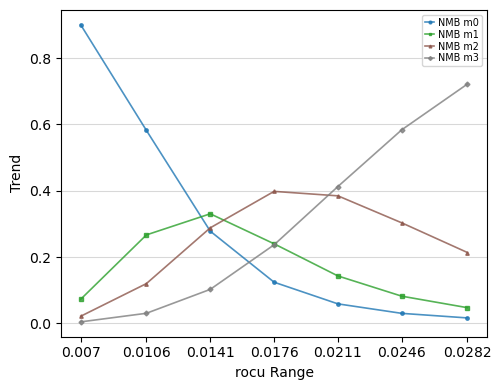

In [10]:
variables = {}

weight = 88
mdr = 12 / 1000 * weight / 60 # [ mcg/kg/min ] mid range dose
step = mdr / 5
rocu_range = [mdr - 3 * step, mdr - 2 * step, mdr - step, mdr, mdr + step, mdr + 2 * step, mdr + 3 * step]
rocu_range = [np.round(value, 4) for value in rocu_range]

variables['prop'] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
variables['remi'] = [2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
variables['nore'] = [0.675, 0.9, 1.125, 1.35, 1.575, 1.8, 2.025]
variables['rocu'] = rocu_range

variables_to_plot = {}
variables_to_plot['prop'] = {'_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR',
                             '_CO_all': 'CO', '_SV_all': 'SV', '_u_prop_all': 'Propofol Input'}
variables_to_plot['remi'] = {'_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR',
                             '_CO_all': 'CO', '_SV_all': 'SV'}
variables_to_plot['nore'] = {'_MAP_all': 'MAP', '_CO_all': 'CO'}
variables_to_plot['rocu'] = {'_NMB_m0_all': 'NMB m0', '_NMB_m1_all': 'NMB m1', '_NMB_m2_all': 'NMB m2','_NMB_m3_all': 'NMB m3'}

scenario_indexes = {}
scenario_indexes['prop'] = [1, 3, 5]
scenario_indexes['remi'] = [3, 4]
scenario_indexes['nore'] = [3]
scenario_indexes['rocu'] = [3]

for variable in variables.keys():
    results = run_simulations(variable, variables[variable], scenario_indexes[variable])
    ylabel = f'Probability at T = 30 min' if variable == 'Rocuronium' else f'Trend'
    plot_trend(results, variable, variables[variable], variables_to_plot[variable], scenario_indexes[variable], y_label=ylabel)